In [7]:
import pandas as pd
from operator import *
from data_extract import *
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import seaborn as sns

In [8]:
final_dataframe = pd.read_csv('Project_data.csv')
final_dataframe = final_dataframe.drop('Unnamed: 0', axis=1)

In [9]:
# Define the linear mixed model
# Define the linear mixed model without backticks

def fixed_effects_formula(include):
    if include == "Sentence_length":
        equation = "Memory_load ~ Dependency_length + Intervener_Complexity + Sentence_length"
        fixed_effects = ["Dependency_length", "Intervener_Complexity", "Sentence_length"]
        return equation ,  fixed_effects
    elif not include:
        equation =  "Memory_load ~ Dependency_length + Intervener_Complexity"
        fixed_effects = ["Dependency_length", "Intervener_Complexity"]
        return equation, fixed_effects


equation, fixed_effects = fixed_effects_formula(include="Sentence_length")

model = smf.mixedlm(equation, # Fixed effects
                    final_dataframe, groups=final_dataframe["language"])
                                 # Random effects 
# Fit the model
result = model.fit()

# Display the summary of the model
print(result.summary())

final_dataframe['Predicted'] = round(result.fittedvalues,1)
final_dataframe['Residuals'] = round(result.resid,1)

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Memory_load
No. Observations:   11500     Method:               REML       
No. Groups:         23        Scale:                8.1156     
Min. group size:    500       Log-Likelihood:       -28431.4042
Max. group size:    500       Converged:            Yes        
Mean group size:    500.0                                      
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.516    0.377  4.018 0.000  0.776  2.255
Dependency_length     0.007    0.002  3.116 0.002  0.003  0.011
Intervener_Complexity 0.031    0.005  6.158 0.000  0.021  0.040
Sentence_length       0.389    0.006 62.391 0.000  0.377  0.401
Group Var             3.216    0.344                           



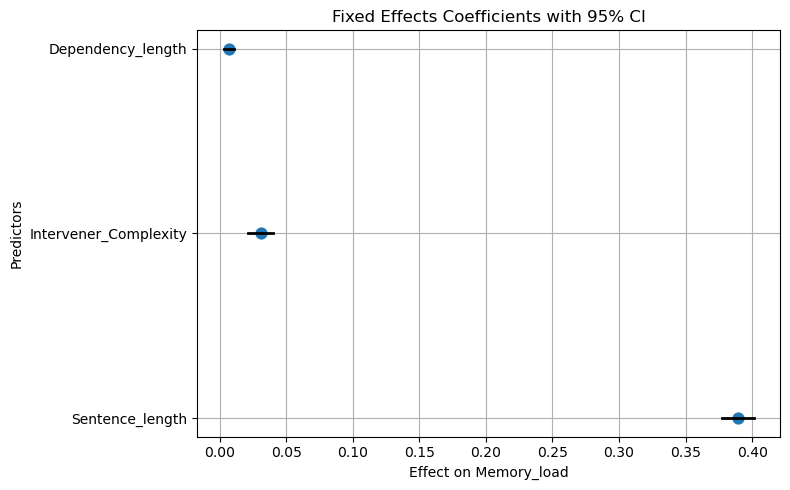

In [10]:
result_data = result.summary().tables[1]

coef_data = {
    'Predictors': fixed_effects,
    'Coefficient': [float(result_data['Coef.'][fe]) for fe in fixed_effects],
    'Lower_CI': [float(result_data['[0.025'][fe]) for fe in fixed_effects],
    'Upper_CI': [float(result_data['0.975]'][fe]) for fe in fixed_effects],
}

coef_df = pd.DataFrame(coef_data)

plt.figure(figsize=(8, 5))
sns.pointplot(
    x="Coefficient",
    y="Predictors",
    data=coef_df,
    capsize=0.3,
    linestyle='none',
    err_kws={'linewidth': 1.5}
)
# Add CI lines manually
for i, row in coef_df.iterrows():
    plt.plot([row["Lower_CI"], row["Upper_CI"]], [i, i], color='black', linewidth=2)
plt.title("Fixed Effects Coefficients with 95% CI")
plt.xlabel("Effect on Memory_load")
plt.ylabel("Predictors")
plt.grid(True)
plt.tight_layout()
plt.show()


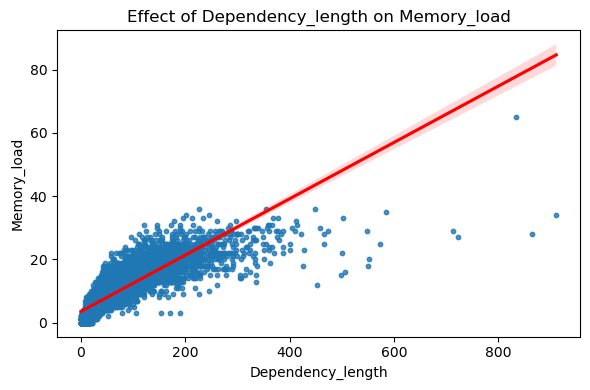

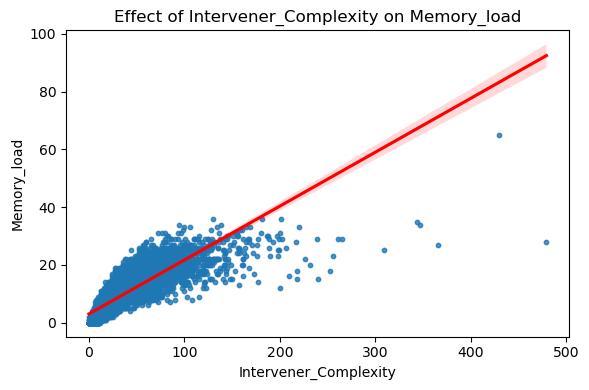

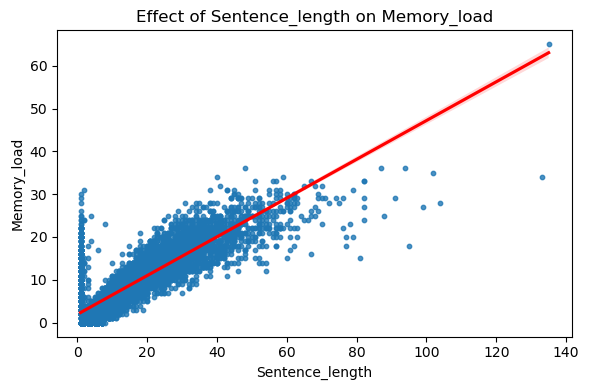

In [11]:
for predictor in fixed_effects:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=predictor, y="Memory_load", data=final_dataframe, scatter_kws={"s": 10}, line_kws={"color": "red"})
    plt.title(f"Effect of {predictor} on Memory_load")
    plt.xlabel(predictor)
    plt.ylabel("Memory_load")
    plt.tight_layout()
    plt.show()


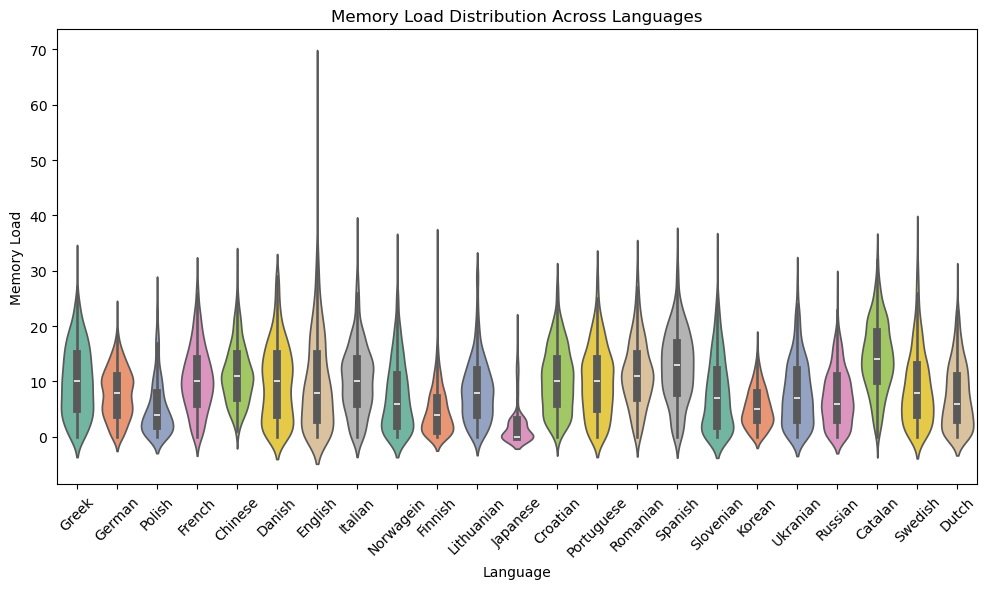

In [19]:
# Create violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='language', y='Memory_load', hue='language', data=final_dataframe,
               inner='box', palette='Set2', legend=False)

plt.title('Memory Load Distribution Across Languages')
plt.xlabel('Language')
plt.ylabel('Memory Load')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = r2_score(final_dataframe['Memory_load'], final_dataframe['Predicted'])
mse = mean_squared_error(final_dataframe['Memory_load'], final_dataframe['Predicted'])
mae = mean_absolute_error(final_dataframe['Memory_load'], final_dataframe['Predicted'])

print(f"R² Score: {r2*100:.2f}%")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


R² Score: 80.91%
Mean Squared Error: 8.0970
Mean Absolute Error: 2.0867


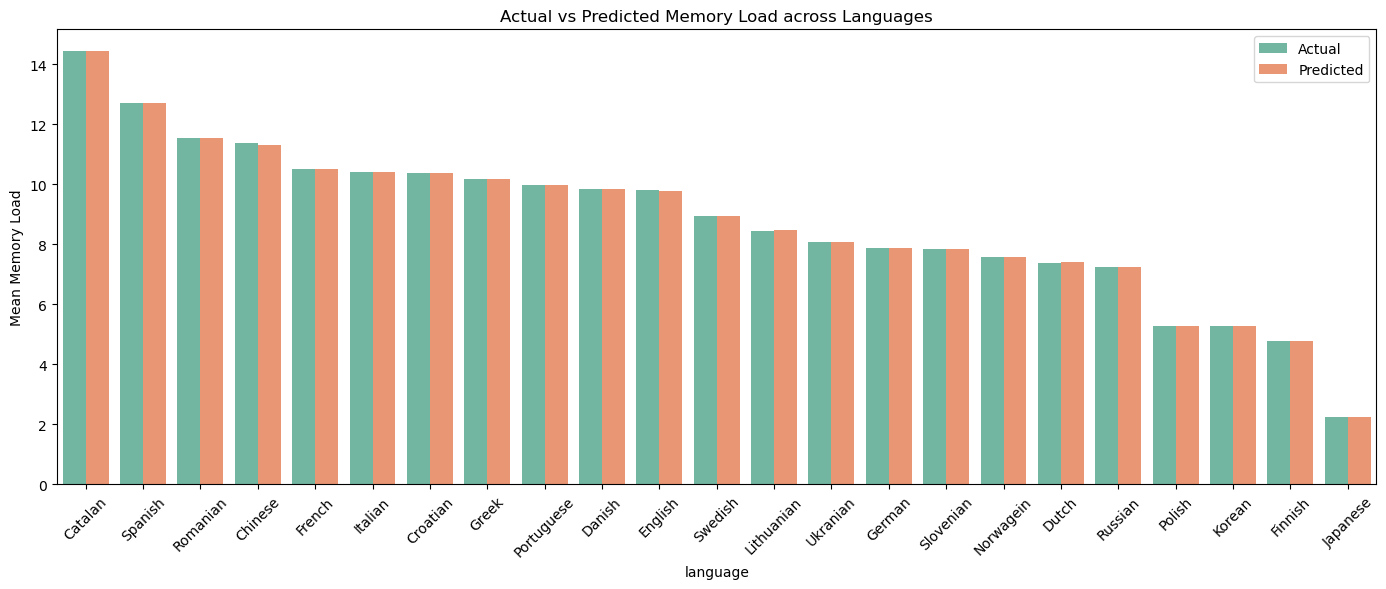

In [33]:
# Calculate mean values
mean_values = final_dataframe.groupby('language')[['Memory_load', 'Predicted']].mean().reset_index()
mean_values = mean_values.sort_values('Memory_load', ascending=False)

# Rename columns for clearer legend labels
mean_values = mean_values.rename(columns={'Memory_load': 'Actual', 'Predicted': 'Predicted'})

# Melt the dataframe for plotting
stacked_df = pd.melt(mean_values, id_vars='language', value_vars=['Actual', 'Predicted'],
                     var_name='Type', value_name='Mean Memory Load')

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x='language', y='Mean Memory Load', hue='Type', data=stacked_df, palette='Set2')

plt.xticks(rotation=45)
plt.title("Actual vs Predicted Memory Load across Languages")

# Remove legend title
plt.legend(title=None)

plt.tight_layout()
plt.show()
